### Baseline

Total TCP retransmission rate: 1.60%
Total Layer 2 retransmission rate: 6.59%
Total packet loss: 0.58%


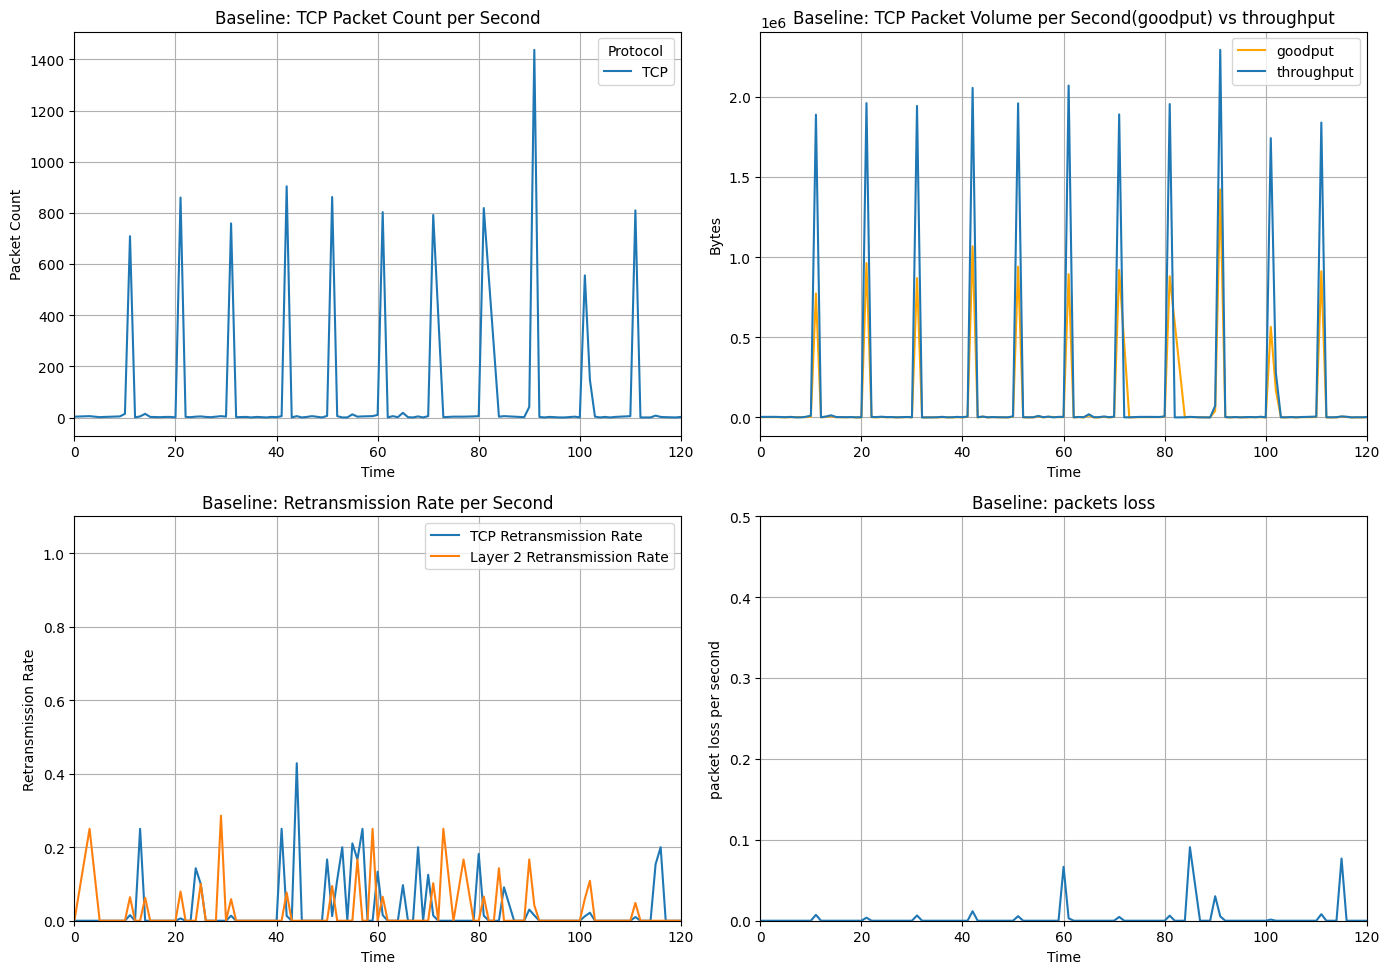

In [39]:
#Baseline: 31s

import pandas as pd
import matplotlib.pyplot as plt

# readcsv
data = pd.read_csv('../csvs/Baseline.csv')
tcp_retrans = pd.read_csv('../csvs/Baseline_tcp_retrans.csv')
layer2_retrans = pd.read_csv('../csvs/Baseline_layer2_retrans.csv')
pkts_loss = pd.read_csv('../csvs/Baseline_pkts_loss.csv')

# preprocess
for df in [data, tcp_retrans, layer2_retrans, pkts_loss]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)


# =========================
# 1. TCP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
start, end = 31, 151
# Filter data to the target time range
mask_total = (data['Time_bin'] >= start) & (data['Time_bin'] <= end)
total_original_count = data.loc[mask_total].shape[0]
total_original_bytes = data.loc[mask_total, 'Length'].sum()

# TCP
total_packet_counts_persecond = data.groupby('Time_bin').size()
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)
mask_tcpretrans = (tcp_retrans['Time_bin'] >= start) & (tcp_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_tcpretrans_bytes = tcp_retrans.loc[mask_tcpretrans, 'Length'].sum()

# Compute retransmission rate 
total_tcp_retrans_rate = total_tcpretrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total TCP retransmission rate: {total_tcp_retrans_rate:.2%}")


# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_l2retrans = (layer2_retrans['Time_bin'] >= start) & (layer2_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_l2retrans_bytes = layer2_retrans.loc[mask_l2retrans, 'Length'].sum()

# Compute retransmission rate 
total_layer2_retrans_rate = total_l2retrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total Layer 2 retransmission rate: {total_layer2_retrans_rate:.2%}")

# =========================
# 3. Throughput (all traffic) and packets loss
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()
pktloss = pkts_loss.groupby('Time_bin').size()
pktloss_per_second = (pktloss / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_pktloss = (pkts_loss['Time_bin'] >= start) & (pkts_loss['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_pkt_loss_count = pkts_loss.loc[mask_pktloss].shape[0]
total_pkt_loss_rate = total_pkt_loss_count / total_original_count
print(f"Total packet loss: {total_pkt_loss_rate:.2%}")

# =========================
# 4. clamping
# =========================

# clamp to desired period
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]
pktloss_per_second = pktloss_per_second.loc[start:end]

# indexes
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start
pktloss_per_second.index = pktloss_per_second.index -start

# =========================
# 5. draw
# =========================
plt.figure(figsize=(14, 10))

# TCP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('Baseline: TCP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
plt.plot(packet_volumes.index, packet_volumes.values, color='orange', label='goodput')
plt.plot(throughput.index, throughput.values, label='throughput')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Baseline: TCP Packet Volume per Second(goodput) vs throughput')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('Baseline: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)
plt.ylim(0, 1.1)

# pkt loss
plt.subplot(2, 2, 4)
plt.plot(pktloss_per_second.index, pktloss_per_second.values)
plt.xlabel('Time')
plt.ylabel('packet loss per second')
plt.title('Baseline: packets loss')
plt.grid(True)
plt.xlim(0, end - start)
plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()


### 4K

Total TCP retransmission rate: 3.33%
Total Layer 2 retransmission rate: 4.49%
Total packet loss: 0.80%


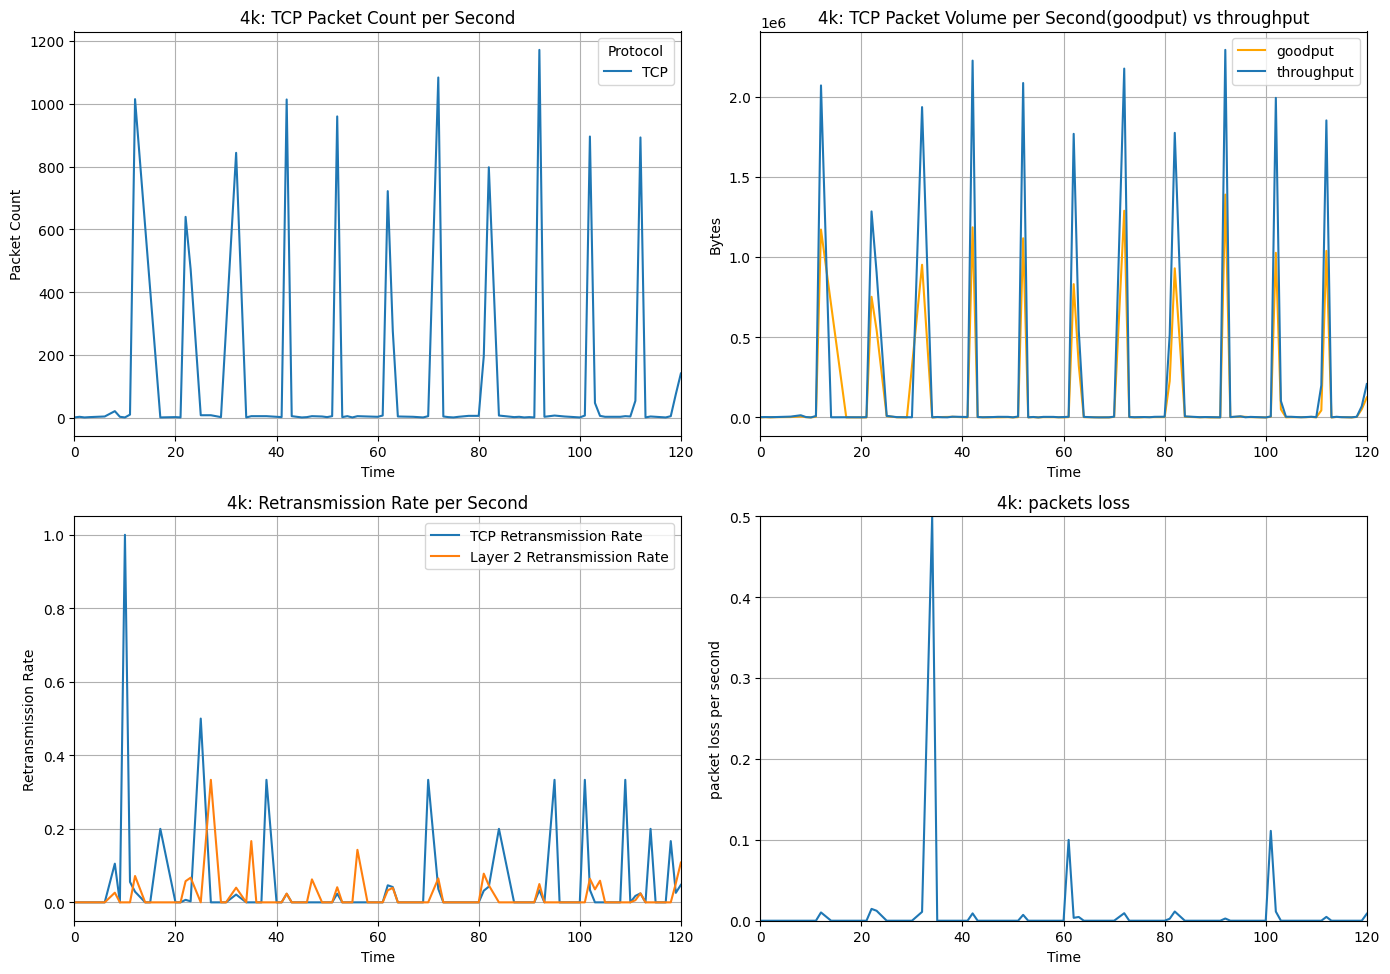

In [ ]:
#4.15
#4k: 29s

import pandas as pd
import matplotlib.pyplot as plt

# readcsv
data = pd.read_csv('../csvs/4k.csv')
tcp_retrans = pd.read_csv('../csvs/4k_tcp_retrans.csv')
layer2_retrans = pd.read_csv('../csvs/4k_layer2_retrans.csv')
pkts_loss = pd.read_csv('../csvs/4k_pkts_loss.csv')

# preprocess
for df in [data, tcp_retrans, layer2_retrans, pkts_loss]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)


# =========================
# 1. TCP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
start, end = 31, 151
# Filter data to the target time range
mask_total = (data['Time_bin'] >= start) & (data['Time_bin'] <= end)
total_original_count = data.loc[mask_total].shape[0]
total_original_bytes = data.loc[mask_total, 'Length'].sum()

# TCP
total_packet_counts_persecond = data.groupby('Time_bin').size()
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)
mask_tcpretrans = (tcp_retrans['Time_bin'] >= start) & (tcp_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_tcpretrans_bytes = tcp_retrans.loc[mask_tcpretrans, 'Length'].sum()

# Compute retransmission rate 
total_tcp_retrans_rate = total_tcpretrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total TCP retransmission rate: {total_tcp_retrans_rate:.2%}")


# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_l2retrans = (layer2_retrans['Time_bin'] >= start) & (layer2_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_l2retrans_bytes = layer2_retrans.loc[mask_l2retrans, 'Length'].sum()

# Compute retransmission rate 
total_layer2_retrans_rate = total_l2retrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total Layer 2 retransmission rate: {total_layer2_retrans_rate:.2%}")

# =========================
# 3. Throughput (all traffic) and packets loss
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()
pktloss = pkts_loss.groupby('Time_bin').size()
pktloss_per_second = (pktloss / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_pktloss = (pkts_loss['Time_bin'] >= start) & (pkts_loss['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_pkt_loss_count = pkts_loss.loc[mask_pktloss].shape[0]
total_pkt_loss_rate = total_pkt_loss_count / total_original_count
print(f"Total packet loss: {total_pkt_loss_rate:.2%}")

# =========================
# 4. clamping
# =========================
start, end = 29, 149
# clamp to desired period
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]
pktloss_per_second = pktloss_per_second.loc[start:end]

# indexes
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start
pktloss_per_second.index = pktloss_per_second.index -start

# =========================
# 5. draw
# =========================
plt.figure(figsize=(14, 10))

# TCP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('4k: TCP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
plt.plot(packet_volumes.index, packet_volumes.values, color='orange', label='goodput')
plt.plot(throughput.index, throughput.values, label='throughput')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('4k: TCP Packet Volume per Second(goodput) vs throughput')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('4k: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)


# pkt loss
plt.subplot(2, 2, 4)
plt.plot(pktloss_per_second.index, pktloss_per_second.values)
plt.xlabel('Time')
plt.ylabel('packet loss per second')
plt.title('4k: packets loss')
plt.grid(True)
plt.xlim(0, end - start)
plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()


### Bluetooth

Total TCP retransmission rate: 1.53%
Total Layer 2 retransmission rate: 9.84%
Total packet loss: 1.18%


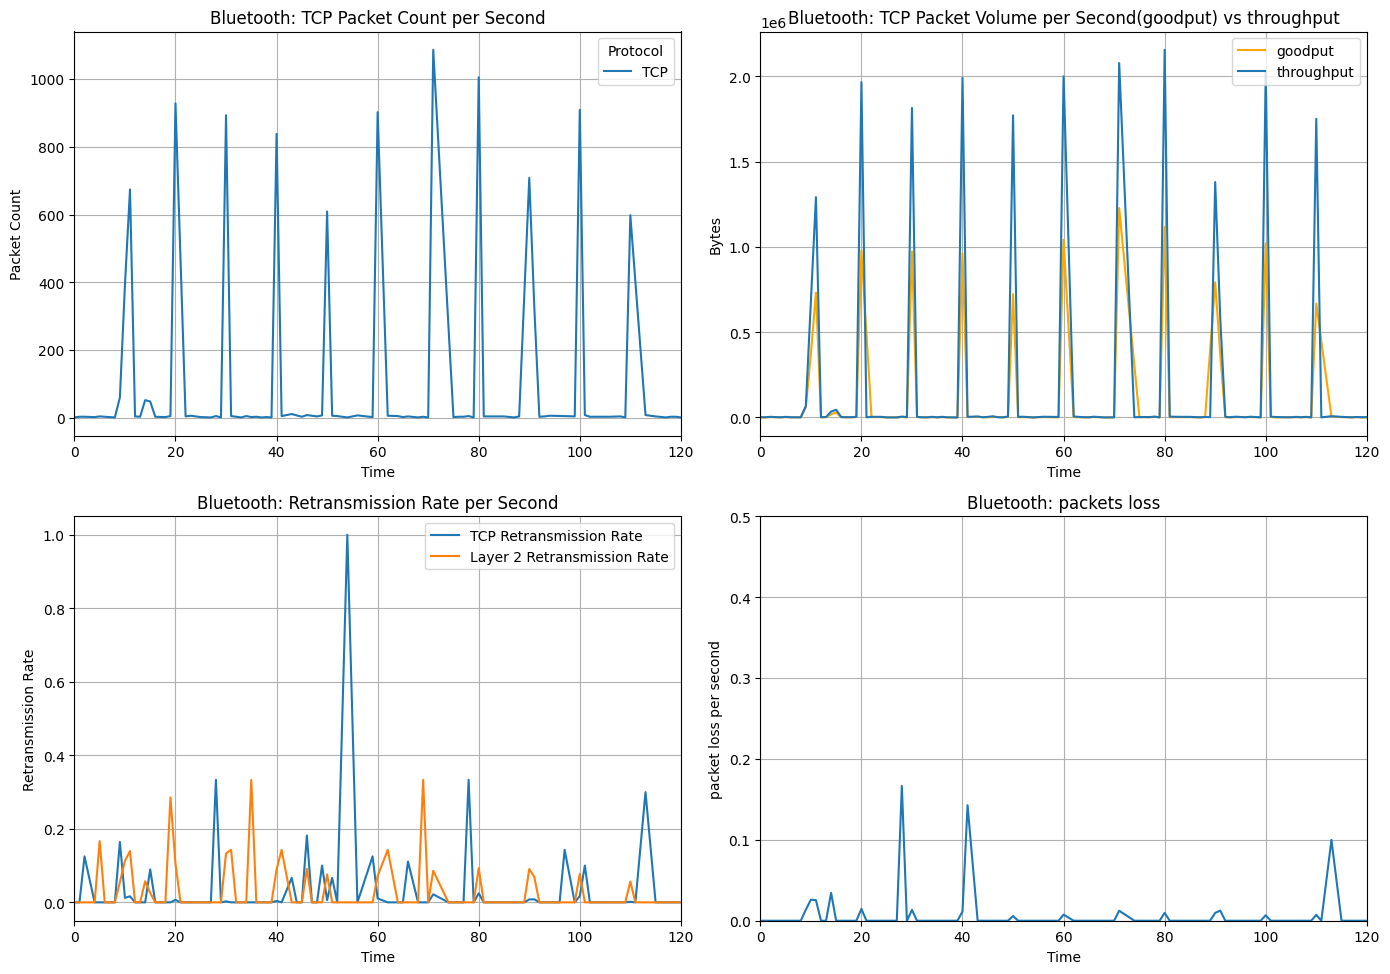

In [36]:
#4.15
#Bluetooth: 44s


import pandas as pd
import matplotlib.pyplot as plt

# readcsv
data = pd.read_csv('../csvs/Bluetooth.csv')
tcp_retrans = pd.read_csv('../csvs/Bluetooth_tcp_retrans.csv')
layer2_retrans = pd.read_csv('../csvs/Bluetooth_layer2_retrans.csv')
pkts_loss = pd.read_csv('../csvs/Bluetooth_pkts_loss.csv')

# preprocess
for df in [data, tcp_retrans, layer2_retrans, pkts_loss]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)


# =========================
# 1. TCP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
start, end = 31, 151
# Filter data to the target time range
mask_total = (data['Time_bin'] >= start) & (data['Time_bin'] <= end)
total_original_count = data.loc[mask_total].shape[0]
total_original_bytes = data.loc[mask_total, 'Length'].sum()

# TCP
total_packet_counts_persecond = data.groupby('Time_bin').size()
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)
mask_tcpretrans = (tcp_retrans['Time_bin'] >= start) & (tcp_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_tcpretrans_bytes = tcp_retrans.loc[mask_tcpretrans, 'Length'].sum()

# Compute retransmission rate 
total_tcp_retrans_rate = total_tcpretrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total TCP retransmission rate: {total_tcp_retrans_rate:.2%}")


# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_l2retrans = (layer2_retrans['Time_bin'] >= start) & (layer2_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_l2retrans_bytes = layer2_retrans.loc[mask_l2retrans, 'Length'].sum()

# Compute retransmission rate 
total_layer2_retrans_rate = total_l2retrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total Layer 2 retransmission rate: {total_layer2_retrans_rate:.2%}")

# =========================
# 3. Throughput (all traffic) and packets loss
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()
pktloss = pkts_loss.groupby('Time_bin').size()
pktloss_per_second = (pktloss / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_pktloss = (pkts_loss['Time_bin'] >= start) & (pkts_loss['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_pkt_loss_count = pkts_loss.loc[mask_pktloss].shape[0]
total_pkt_loss_rate = total_pkt_loss_count / total_original_count
print(f"Total packet loss: {total_pkt_loss_rate:.2%}")

# =========================
# 4. clamping
# =========================
start, end = 44, 164
# clamp to desired period
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]
pktloss_per_second = pktloss_per_second.loc[start:end]

# indexes
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start
pktloss_per_second.index = pktloss_per_second.index -start

# =========================
# 5. draw
# =========================
plt.figure(figsize=(14, 10))

# TCP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('Bluetooth: TCP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
plt.plot(packet_volumes.index, packet_volumes.values, color='orange', label='goodput')
plt.plot(throughput.index, throughput.values, label='throughput')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Bluetooth: TCP Packet Volume per Second(goodput) vs throughput')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('Bluetooth: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# packet loss
plt.subplot(2, 2, 4)
plt.plot(pktloss_per_second.index, pktloss_per_second.values)
plt.xlabel('Time')
plt.ylabel('packet loss per second')
plt.title('Bluetooth: packets loss')
plt.grid(True)
plt.xlim(0, end - start)
plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()


Total TCP retransmission rate: 0.67%
Total Layer 2 retransmission rate: 11.94%
Total packet loss: 1.50%


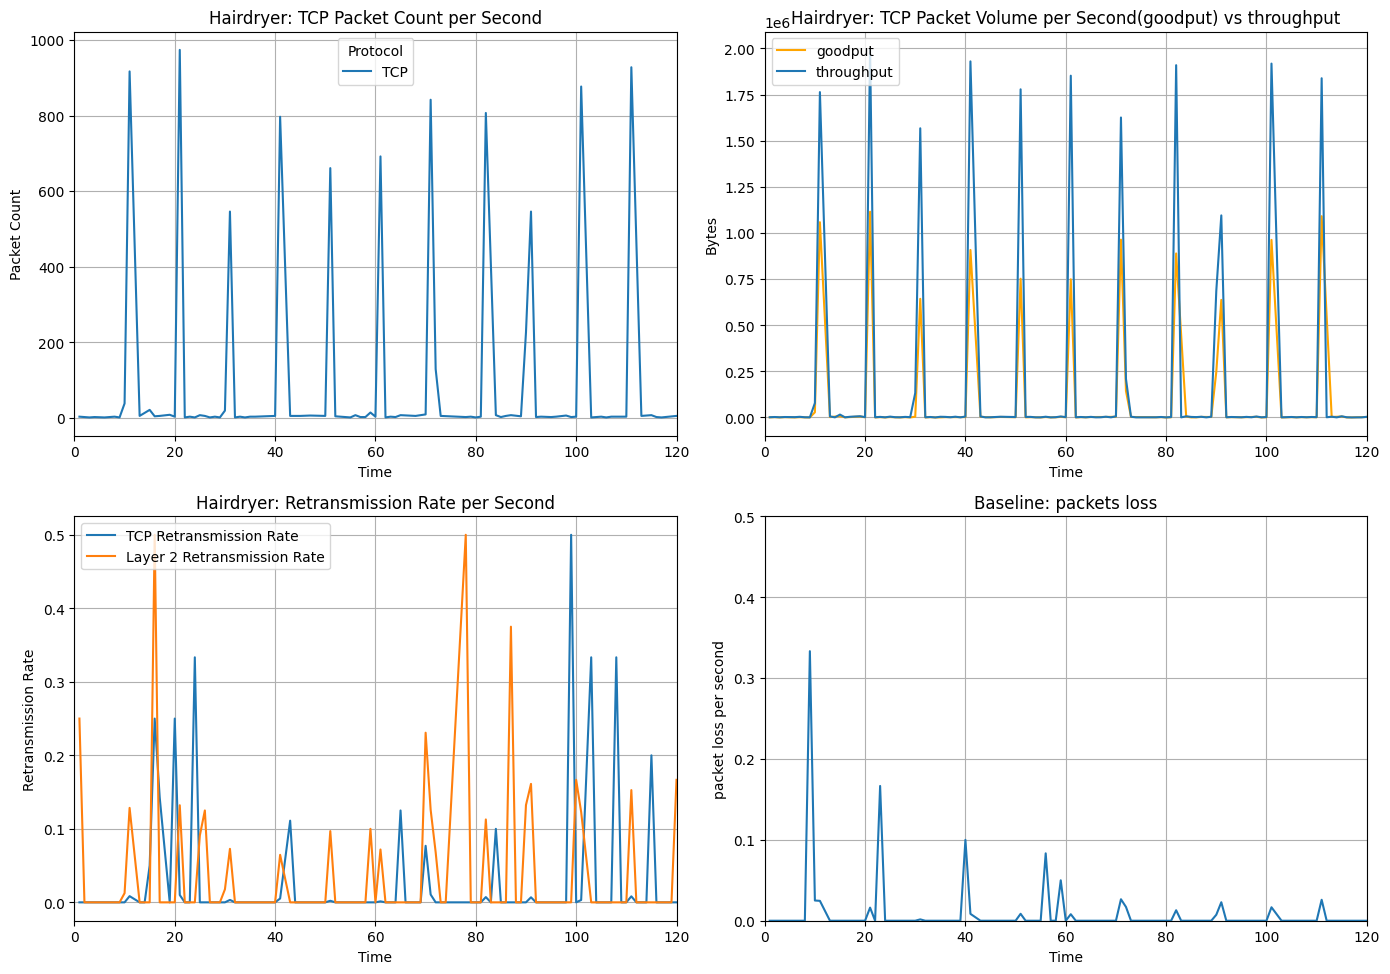

In [ ]:
#4.15
#Hair: 35s

import pandas as pd
import matplotlib.pyplot as plt

# readcsv
data = pd.read_csv('../csvs/Hairdryer.csv')
tcp_retrans = pd.read_csv('../csvs/Hairdryer_tcp_retrans.csv')
layer2_retrans = pd.read_csv('../csvs/Hairdryer_layer2_retrans.csv')
pkts_loss = pd.read_csv('../csvs/Hairdryer_pkts_loss.csv')

# preprocess
for df in [data, tcp_retrans, layer2_retrans, pkts_loss]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)


# =========================
# 1. TCP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
start, end = 31, 151
# Filter data to the target time range
mask_total = (data['Time_bin'] >= start) & (data['Time_bin'] <= end)
total_original_count = data.loc[mask_total].shape[0]
total_original_bytes = data.loc[mask_total, 'Length'].sum()

# TCP
total_packet_counts_persecond = data.groupby('Time_bin').size()
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)
mask_tcpretrans = (tcp_retrans['Time_bin'] >= start) & (tcp_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_tcpretrans_bytes = tcp_retrans.loc[mask_tcpretrans, 'Length'].sum()

# Compute retransmission rate 
total_tcp_retrans_rate = total_tcpretrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total TCP retransmission rate: {total_tcp_retrans_rate:.2%}")


# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_l2retrans = (layer2_retrans['Time_bin'] >= start) & (layer2_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_l2retrans_bytes = layer2_retrans.loc[mask_l2retrans, 'Length'].sum()

# Compute retransmission rate 
total_layer2_retrans_rate = total_l2retrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total Layer 2 retransmission rate: {total_layer2_retrans_rate:.2%}")

# =========================
# 3. Throughput (all traffic) and packets loss
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()
pktloss = pkts_loss.groupby('Time_bin').size()
pktloss_per_second = (pktloss / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_pktloss = (pkts_loss['Time_bin'] >= start) & (pkts_loss['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_pkt_loss_count = pkts_loss.loc[mask_pktloss].shape[0]
total_pkt_loss_rate = total_pkt_loss_count / total_original_count
print(f"Total packet loss: {total_pkt_loss_rate:.2%}")

# =========================
# 4. clamping
# =========================
start, end = 35, 155
# clamp to desired period
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]
pktloss_per_second = pktloss_per_second.loc[start:end]

# indexes
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start
pktloss_per_second.index = pktloss_per_second.index -start

# =========================
# 5. draw
# =========================
plt.figure(figsize=(14, 10))

# TCP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('Hairdryer: TCP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
plt.plot(packet_volumes.index, packet_volumes.values, color='orange', label='goodput')
plt.plot(throughput.index, throughput.values, label='throughput')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Hairdryer: TCP Packet Volume per Second(goodput) vs throughput')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('Hairdryer: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)
plt.ylim(0, 1.1)


# packet loss
plt.subplot(2, 2, 4)
plt.plot(pktloss_per_second.index, pktloss_per_second.values)
plt.xlabel('Time')
plt.ylabel('packet loss per second')
plt.title('Baseline: packets loss')
plt.grid(True)
plt.xlim(0, end - start)
plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()


Total TCP retransmission rate: 1.65%
Total Layer 2 retransmission rate: 8.32%
Total packet loss: 0.93%


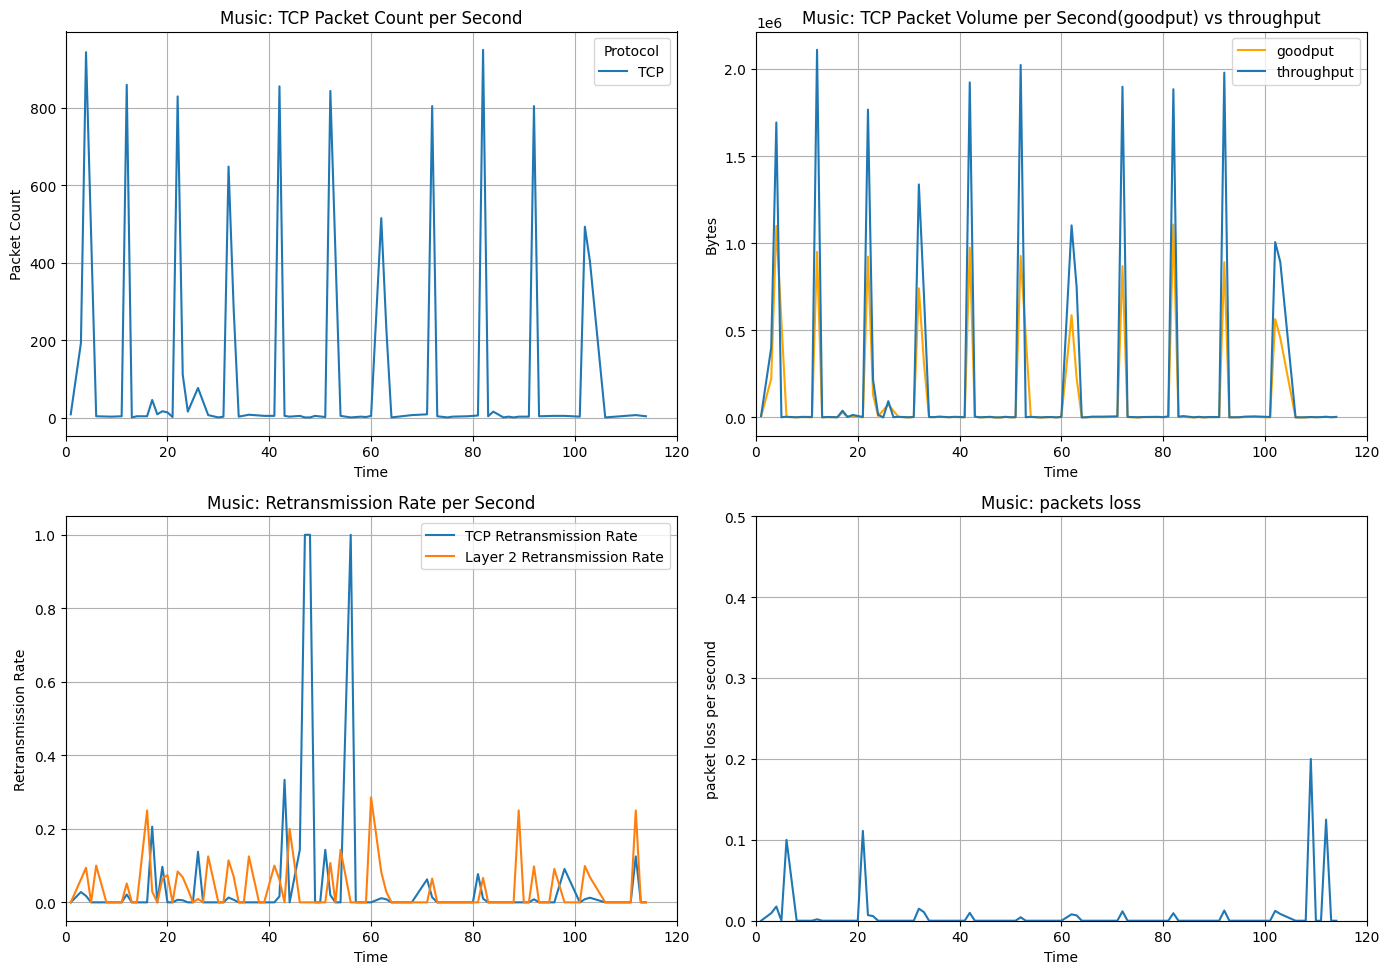

In [38]:
#4.15
#music: 26s


import pandas as pd
import matplotlib.pyplot as plt

# readcsv
data = pd.read_csv('../csvs/Music.csv')
tcp_retrans = pd.read_csv('../csvs/Music_tcp_retrans.csv')
layer2_retrans = pd.read_csv('../csvs/Music_layer2_retrans.csv')
pkts_loss = pd.read_csv('../csvs/Music_pkts_loss.csv')

# preprocess
for df in [data, tcp_retrans, layer2_retrans, pkts_loss]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)


# =========================
# 1. TCP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
start, end = 31, 151
# Filter data to the target time range
mask_total = (data['Time_bin'] >= start) & (data['Time_bin'] <= end)
total_original_count = data.loc[mask_total].shape[0]
total_original_bytes = data.loc[mask_total, 'Length'].sum()

# TCP
total_packet_counts_persecond = data.groupby('Time_bin').size()
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)
mask_tcpretrans = (tcp_retrans['Time_bin'] >= start) & (tcp_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_tcpretrans_bytes = tcp_retrans.loc[mask_tcpretrans, 'Length'].sum()

# Compute retransmission rate 
total_tcp_retrans_rate = total_tcpretrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total TCP retransmission rate: {total_tcp_retrans_rate:.2%}")


# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_l2retrans = (layer2_retrans['Time_bin'] >= start) & (layer2_retrans['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_l2retrans_bytes = layer2_retrans.loc[mask_l2retrans, 'Length'].sum()

# Compute retransmission rate 
total_layer2_retrans_rate = total_l2retrans_bytes / total_original_bytes if total_original_bytes > 0 else 0
print(f"Total Layer 2 retransmission rate: {total_layer2_retrans_rate:.2%}")

# =========================
# 3. Throughput (all traffic) and packets loss
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()
pktloss = pkts_loss.groupby('Time_bin').size()
pktloss_per_second = (pktloss / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

mask_pktloss = (pkts_loss['Time_bin'] >= start) & (pkts_loss['Time_bin'] <= end)
# Calculate total lengths in the clamped range
total_pkt_loss_count = pkts_loss.loc[mask_pktloss].shape[0]
total_pkt_loss_rate = total_pkt_loss_count / total_original_count
print(f"Total packet loss: {total_pkt_loss_rate:.2%}")

# =========================
# 4. clamping
# =========================
start, end = 35, 155
# clamp to desired period
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]
pktloss_per_second = pktloss_per_second.loc[start:end]

# indexes
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start
pktloss_per_second.index = pktloss_per_second.index -start

# =========================
# 5. draw
# =========================
plt.figure(figsize=(14, 10))

# TCP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('Music: TCP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
plt.plot(packet_volumes.index, packet_volumes.values, color='orange', label='goodput')
plt.plot(throughput.index, throughput.values, label='throughput')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Music: TCP Packet Volume per Second(goodput) vs throughput')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('Music: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# pkt loss
plt.subplot(2, 2, 4)
plt.plot(pktloss_per_second.index, pktloss_per_second.values)
plt.xlabel('Time')
plt.ylabel('packet loss per second')
plt.title('Music: packets loss')
plt.grid(True)
plt.xlim(0, end - start)
plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()



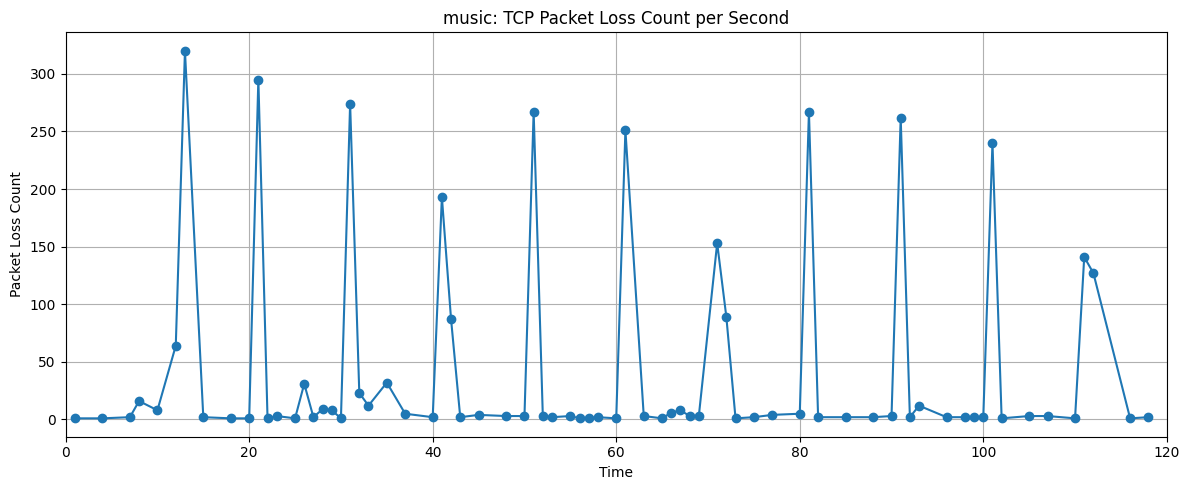

Total inferred TCP packet loss count: 3295


In [ ]:
# import pandas as pd
# import re
# import matplotlib.pyplot as plt

# # 读取CSV
# df = pd.read_csv('music.csv')  # 修改成你的实际CSV文件名

# # 提取 TCP Seq
# def extract_seq(info):
#     match = re.search(r'Seq=(\d+)', str(info))
#     return int(match.group(1)) if match else None

# # 预处理
# df['Seq'] = df['Info'].apply(extract_seq)
# df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
# df.dropna(subset=['Seq', 'Time'], inplace=True)

# # 保证只分析TCP包（如果有Protocol列）
# if 'Protocol' in df.columns:
#     df = df[df['Protocol'] == 'TCP']

# # 按 Seq 升序 + Time 升序排序
# df.sort_values(by=['Seq', 'Time'], inplace=True)

# # 给每个 packet 添加发送次数编号（第一次发送是0，第二次发送是1，依此类推）
# df['Seq_Send_Count'] = df.groupby('Seq').cumcount()

# # 只保留 retransmission 包（即发送次数编号 > 0）
# retransmissions = df[df['Seq_Send_Count'] > 0].copy()

# # 把 retransmission 按 timestamp 秒数分组
# retransmissions['Time_sec'] = retransmissions['Time'].astype(int)

# # 只保留 31s 到 151s 的丢包数据
# start, end = 26, 146
# retransmissions = retransmissions[(retransmissions['Time_sec'] >= start) & (retransmissions['Time_sec'] <= end)]

# # 重新映射时间：让31秒变成0秒
# retransmissions['Time_mapped'] = retransmissions['Time_sec'] - start

# # 每秒丢包数量
# packet_loss_per_sec = retransmissions.groupby('Time_mapped').size()

# # =========================
# # 绘制每秒丢包数量
# # =========================
# plt.figure(figsize=(12, 5))
# plt.plot(packet_loss_per_sec.index, packet_loss_per_sec.values, marker='o', linestyle='-')
# plt.xlabel('Time')
# plt.ylabel('Packet Loss Count')
# plt.title('music: TCP Packet Loss Count per Second')
# plt.grid(True)
# plt.xlim(0, end - start)
# plt.tight_layout()
# plt.show()

# # =========================
# # 打印总丢包数（在31~151s范围内）
# # =========================
# total_packet_loss = len(retransmissions)
# print("Total inferred TCP packet loss count:", total_packet_loss)
